

# **TRAINING XGBoost**

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from category_encoders import HashingEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
import pprint

df_model_ready = df_merged_final.copy()

Y = df_model_ready['is_fraud']
X = df_model_ready.drop(
    columns=['is_fraud', 'user_id', 'docno', 'transdate', 'timestamp'],
    errors='ignore'
)

X = X.fillna(0)

cat_cols = final_categorical_features

X_train_raw, X_holdout_raw, y_train, y_holdout = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=Y,
    random_state=42
)

encoder = HashingEncoder(cols=cat_cols, n_components=8)

X_train = encoder.fit_transform(X_train_raw)
X_holdout = encoder.transform(X_holdout_raw)


In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight_value = neg / pos
random_state = 42

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.03, 0.05, 0.1],
    'gamma': [0, 0.5, 1],
    'subsample': [0.7, 0.9],
    'n_estimators': [100, 150]
}

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight_value,
    random_state=random_state,
    tree_method="hist",
    eval_metric='aucpr'
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
def evaluate(trainedmodel, x, y):
    y_pred = trainedmodel.predict(x)
    f1 = f1_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    y_pred_proba = trainedmodel.predict_proba(x)[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)

    report = classification_report(y, y_pred)

    return {
        'f1_score': f1,
        'accuracy': acc,
        'roc_auc_score': roc_auc
    }, report

eval_holdout, report_holdout = evaluate(best_xgb_model, X_holdout, y_holdout)

print("Лучшие параметры:", grid_search.best_params_)
print("CV ROC-AUC:", grid_search.best_score_)
print("\nHoldout evaluation:")
pprint.pprint(eval_holdout)
print("\n", report_holdout)

Лучшие параметры: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
CV ROC-AUC: 0.975118238897814

Holdout evaluation:
{'accuracy': 0.9801753717117804,
 'f1_score': 0.43478260869565216,
 'roc_auc_score': np.float64(0.9793962793962795)}

               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2590
           1       0.34      0.61      0.43        33

    accuracy                           0.98      2623
   macro avg       0.67      0.80      0.71      2623
weighted avg       0.99      0.98      0.98      2623



In [ ]:
# Метрики на TRAIN
train_eval, train_report = evaluate(best_xgb_model, X_train, y_train)
print("Train evaluation:")
print(train_eval)
print(train_report)

# Метрики на HOLDOUT
holdout_eval, holdout_report = evaluate(best_xgb_model, X_holdout, y_holdout)
print("Holdout evaluation:")
print(holdout_eval)
print(holdout_report)

Train evaluation:
{'f1_score': 0.832807570977918, 'accuracy': 0.9949475691134414, 'roc_auc_score': np.float64(0.9999787896341286)}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     10358
           1       0.71      1.00      0.83       132

    accuracy                           0.99     10490
   macro avg       0.86      1.00      0.92     10490
weighted avg       1.00      0.99      1.00     10490

Holdout evaluation:
{'f1_score': 0.43478260869565216, 'accuracy': 0.9801753717117804, 'roc_auc_score': np.float64(0.9793962793962795)}
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2590
           1       0.34      0.61      0.43        33

    accuracy                           0.98      2623
   macro avg       0.67      0.80      0.71      2623
weighted avg       0.99      0.98      0.98      2623



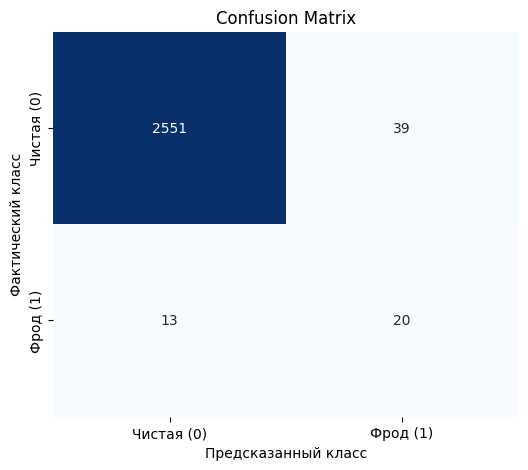

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_holdout_pred = best_xgb_model.predict(X_holdout)

cm = confusion_matrix(y_holdout, y_holdout_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=False,
    xticklabels=['Чистая (0)', 'Фрод (1)'],
    yticklabels=['Чистая (0)', 'Фрод (1)']
)
plt.title('Confusion Matrix')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

--- 📈 Расчет ROC AUC ---
Финальная метрика ROC AUC: 0.9794


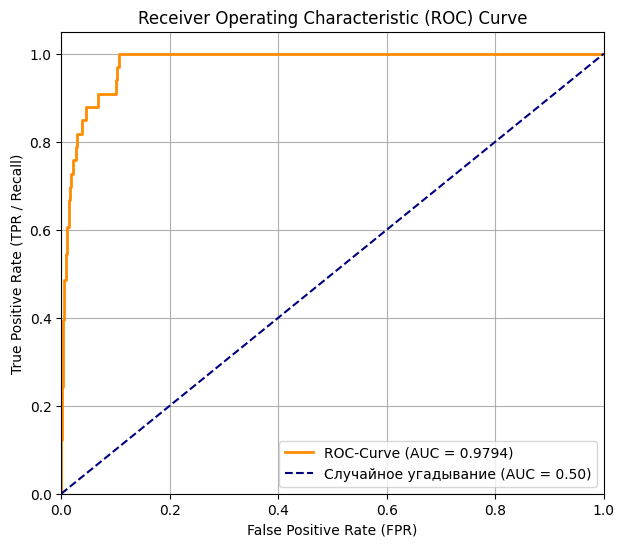

In [ ]:
# Расчет Метрики ROC AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

y_proba_holdout = best_xgb_model.predict_proba(X_holdout)[:, 1]

roc_auc = roc_auc_score(y_holdout, y_proba_holdout)

fpr, tpr, thresholds = roc_curve(y_holdout, y_proba_holdout)

plt.figure(figsize=(7, 6))

plt.plot(
    fpr,
    tpr,
    label=f'ROC-Curve (AUC = {roc_auc:.4f})',
    color='darkorange',
    lw=2
)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Случайное угадывание (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
# сохранить модель
import joblib

drive_path = '/content/gdrive/My Drive/Hackaton/XGBoost_model_final.pkl'

joblib.dump(best_xgb_model, drive_path)

['/content/gdrive/My Drive/Hackaton/XGBoost_model_final.pkl']

# **НАСТРОЙКА ПОРОГОВ**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score

y_proba_holdout = best_xgb_model.predict_proba(X_holdout)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_holdout, y_proba_holdout)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_f1_index = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_index]

print("Анализ Порога (Максимум F1-score)")
print(f"Порог, максимизирующий F1: {best_threshold_f1:.4f}")
print(f"Precision при F1-max: {precision[best_f1_index]:.4f}")
print(f"Recall при F1-max: {recall[best_f1_index]:.4f}")




--- Анализ Порога (Максимум F1-score) ---
Порог, максимизирующий F1: 0.8453
Precision при F1-max: 0.5161
Recall при F1-max: 0.4848



--- 🏁 Финальная Оценка с Порогом: 0.67 ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2590
           1       0.40      0.58      0.47        33

    accuracy                           0.98      2623
   macro avg       0.70      0.78      0.73      2623
weighted avg       0.99      0.98      0.99      2623



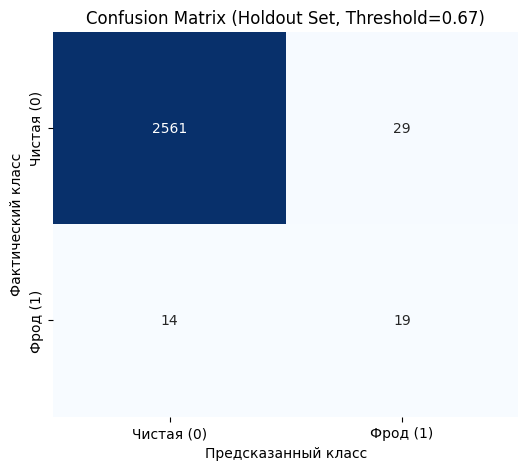

In [ ]:
NEW_THRESHOLD = 0.67

y_holdout_pred_optimized = np.where(y_proba_holdout >= NEW_THRESHOLD, 1, 0)

print(classification_report(y_holdout, y_holdout_pred_optimized))

cm_optimized = confusion_matrix(y_holdout, y_holdout_pred_optimized)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_optimized,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=False,
    xticklabels=['Чистая (0)', 'Фрод (1)'],
    yticklabels=['Чистая (0)', 'Фрод (1)']
)
plt.title(f'Confusion Matrix (Holdout Set, Threshold={NEW_THRESHOLD})')
plt.ylabel('Фактический класс')
plt.xlabel('Предсказанный класс')
plt.show()

# **LGBM**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from lightgbm import LGBMClassifier
from category_encoders import HashingEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score
import pprint

df_model_ready = df_merged_final.copy()

Y = df_model_ready['is_fraud']
X = df_model_ready.drop(
    columns=['is_fraud', 'user_id', 'docno', 'transdate', 'timestamp'],
    errors='ignore'
)

X = X.fillna(0)

cat_cols = final_categorical_features

X_train_raw, X_holdout_raw, y_train, y_holdout = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=Y,
    random_state=42
)

random_state = 42

neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight_value = neg / pos
print("scale_pos_weight:", scale_pos_weight_value)

encoder = HashingEncoder(cols=cat_cols, n_components=8)

X_train = encoder.fit_transform(X_train_raw)
X_holdout = encoder.transform(X_holdout_raw)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'num_leaves': [16, 31, 63],
    'max_depth': [-1, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400],
    'subsample': [0.7, 0.9],
}

lgbm = LGBMClassifier(
    objective='binary',
    class_weight=None,
    is_unbalance=False,
    scale_pos_weight=scale_pos_weight_value,
    random_state=random_state,
    boosting_type='gbdt'
)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_lgbm = grid_search.best_estimator_

def evaluate(trainedmodel, x, y):
    y_pred = trainedmodel.predict(x)
    f1 = f1_score(y, y_pred)
    acc = accuracy_score(y, y_pred)
    y_pred_proba = trainedmodel.predict_proba(x)[:, 1]
    roc_auc = roc_auc_score(y, y_pred_proba)
    report = classification_report(y, y_pred)
    return {
        'f1_score': f1,
        'accuracy': acc,
        'roc_auc_score': roc_auc
    }, report


eval_holdout, report_holdout = evaluate(best_lgbm, X_holdout, y_holdout)

print("Лучшие параметры:", grid_search.best_params_)
print("CV ROC-AUC:", grid_search.best_score_)
print("\nHoldout evaluation:")
pprint.pprint(eval_holdout)
print("\n", report_holdout)

scale_pos_weight: 78.46969696969697
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Number of positive: 132, number of negative: 10358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4134
[LightGBM] [Info] Number of data points in the train set: 10490, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012583 -> initscore=-4.362713
[LightGBM] [Info] Start training from score -4.362713
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 400, 'num_leaves': 31, 'subsample': 0.7}
CV ROC-AUC: 0.9744630650835383

Holdout evaluation:
{'accuracy': 0.9847502859321388,
 'f1_score': 0.5121951219512195,
 'roc_auc_score': np.float64(0.983011583011583)}

               precision    recall  f1-score   support

     

In [ ]:
# Метрики на TRAIN
train_eval, train_report = evaluate(best_lgbm, X_train, y_train)
print("Train evaluation:")
print(train_eval)
print(train_report)

# Метрики на HOLDOUT
holdout_eval, holdout_report = evaluate(best_lgbm, X_holdout, y_holdout)
print("Holdout evaluation:")
print(holdout_eval)
print(holdout_report)

Train evaluation:
{'f1_score': 0.8888888888888888, 'accuracy': 0.9968541468064823, 'roc_auc_score': np.float64(1.0)}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10358
           1       0.80      1.00      0.89       132

    accuracy                           1.00     10490
   macro avg       0.90      1.00      0.94     10490
weighted avg       1.00      1.00      1.00     10490

Holdout evaluation:
{'f1_score': 0.5121951219512195, 'accuracy': 0.9847502859321388, 'roc_auc_score': np.float64(0.983011583011583)}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2590
           1       0.43      0.64      0.51        33

    accuracy                           0.98      2623
   macro avg       0.71      0.81      0.75      2623
weighted avg       0.99      0.98      0.99      2623



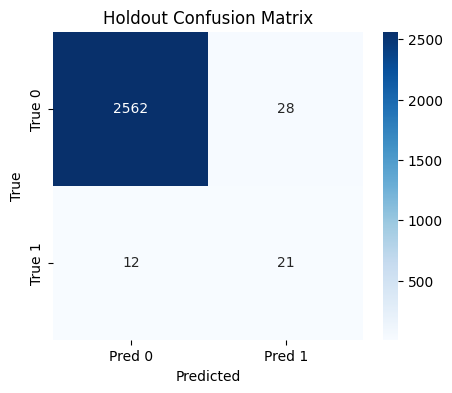

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, X, y, title="Confusion Matrix"):
    y_pred = model.predict(X)

    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
plot_confusion_matrix(best_lgbm, X_holdout, y_holdout, "Holdout Confusion Matrix")

# **ANALYZING IMPORTANCE**

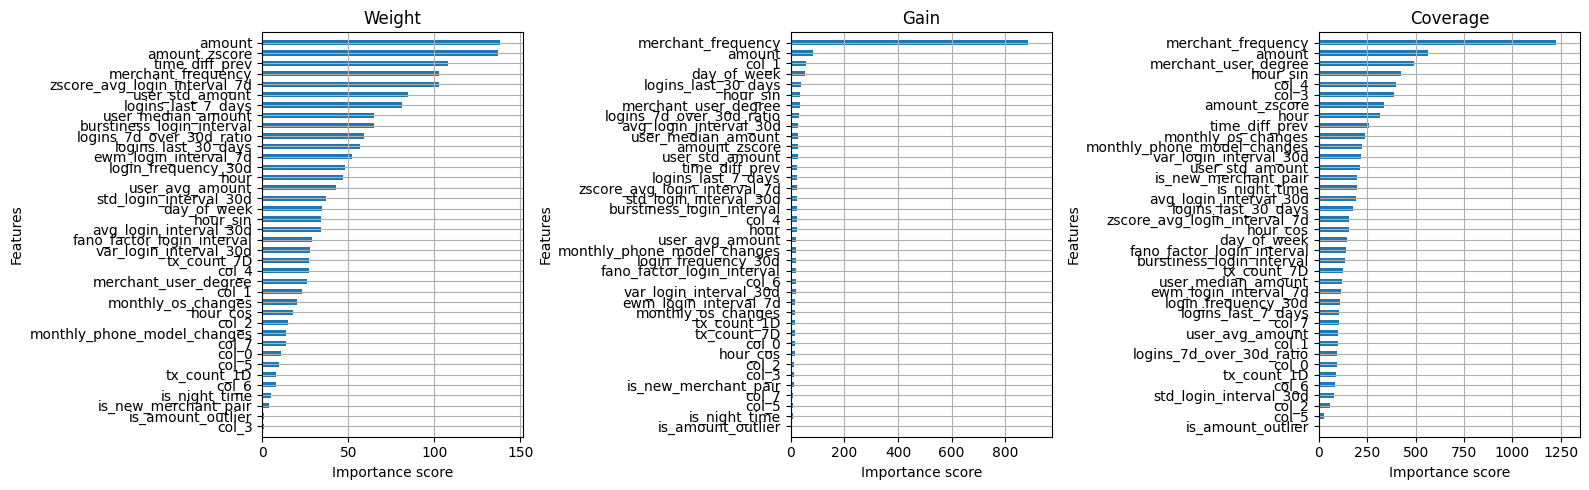

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(1, 3, figsize=(16,5))

plot_importance(booster=best_xgb_model, importance_type='weight', title='Weight', show_values=False, height=0.5, ax = ax[0])

# plot importances with split mean gain
plot_importance(booster=best_xgb_model, importance_type='gain', title='Gain', show_values=False, height=0.5, ax = ax[1])

# plot importances with sample coverage
plot_importance( booster=best_xgb_model, importance_type='cover', title='Coverage', show_values=False, height=0.5, ax = ax[2])

plt.tight_layout()
plt.show()

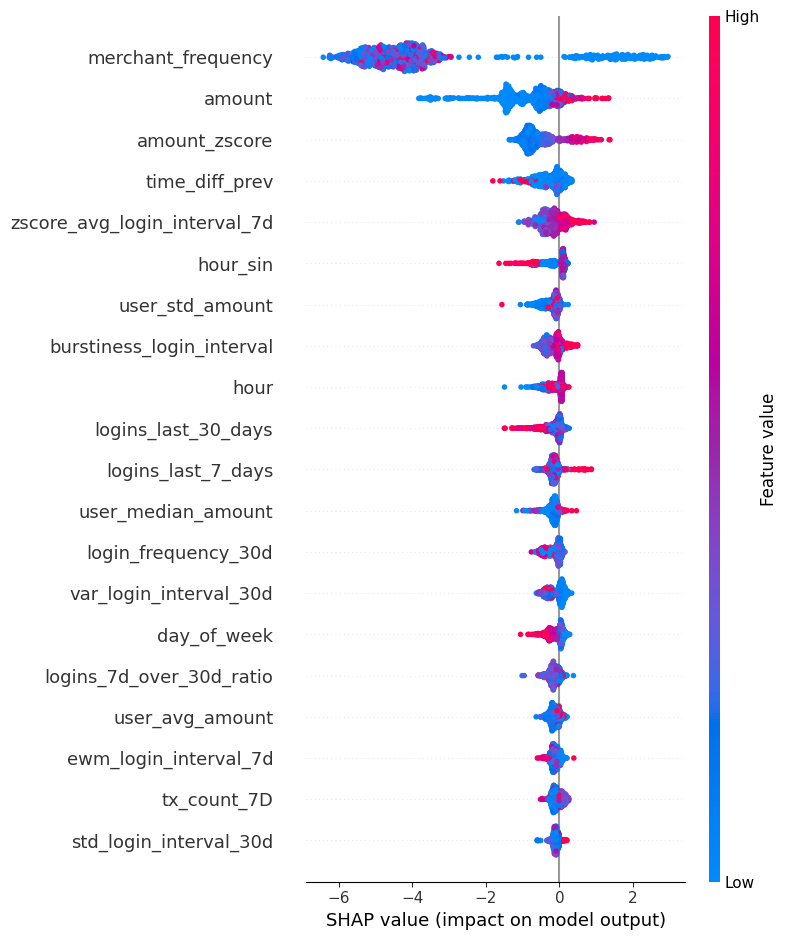

In [ ]:
import shap

x_test_sample_df = X_holdout.sample(1000, random_state=42)

explainer = shap.TreeExplainer(best_xgb_model)

shap_values = explainer.shap_values(x_test_sample_df)

if len(shap_values.shape) == 2:
    shap_values_matrix = shap_values
else:
    shap_values_matrix = shap_values[1]

shap.summary_plot(
    shap_values_matrix,
    x_test_sample_df,
    feature_names=x_test_sample_df.columns
)